In [1]:
import json
import re
import numpy as np
np.random.seed(2019)
import pandas as pd
from string import punctuation 

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
import emoji
import collections

import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel

from pycontractions import Contractions

import matplotlib.pyplot as plt
import matplotlib

from py4j.java_gateway import JavaGateway

In [2]:
gateway = JavaGateway()

In [3]:
with open('coor_to_sa2.json') as json_file:
    data = json.load(json_file)

In [4]:
stop = set(stopwords.words('english')+ list(punctuation))
def preprocess(sentence):
    sent = sentence.lower()
    sent = re.sub('\(via.*\)', '', sent)
    sent = re.sub('(@[^\s]+)', '', sent) ## Remove @ hashtags
    sent = re.sub('\s+', ' ', sent) ## Remove new line characters
    sent = re.sub('\S*@\S*\s?', '', sent) ## Remove Emails
    sent = re.sub("\'", "", sent)  ## Remove distracting single quotes
    sent = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', sent) ##Remove urls
    sent = re.sub(r'#([^\s]+)', r'\1', sent) ##Remove # hashtags
    sent = ' '.join(emoji.demojize(sent).replace(":"," ").split())
    sent = re.sub(r'[^\w\s]','',sent) ## Remove punctuation
    return sent

def contains_letters(phrase):
    return bool(re.search('[a-zA-Z]', phrase))

### original version: gensim LDA

In [607]:
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer() 
clean_tweet = {}
for i in data:
    clean = []
    for t in range(len(data[i])):
        tweet = preprocess(data[i][t])
        tokenized_tweet = word_tokenize(tweet)
        stem_tweet = [ps.stem(w) for w in tokenized_tweet]
        clean.append([w for w in stem_tweet if w not in stop if len(w) >3 if contains_letters(w) if not any(w1.isdigit() for w1 in w)])
    clean_tweet[i] = clean

In [608]:
tweet_bow = {}
tweet_bow_list = []
for i in clean_tweet:
    bow = []
    for l in clean_tweet[i]:
        for w in l:
            bow.append(w)
    tweet_bow_list.append(bow)
    tweet_bow[i] = bow

In [310]:
## 词频统计
frequency = {}
frequency=collections.Counter(tweet_bow)

In [369]:
gensim_lda_topic = {}
lda_score = {}
for i in tweet_bow:
    if len(tweet_bow[i]) ==0:
        continue
    id2word = corpora.Dictionary([tweet_bow[i]])
    corpus = [id2word.doc2bow(w) for w in [tweet_bow[i]]]
    NUM_TOPICS = 5
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=id2word,update_every=1, alpha='auto',passes=20)
    topics = ldamodel.print_topics(num_words=3)
    coherence_model_lda = CoherenceModel(model=ldamodel, texts=[tweet_bow[i]], dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    gensim_lda_topic[i] = topics
    lda_score[i] = [ldamodel.log_perplexity(corpus),coherence_lda]

In [370]:
gensim_lda_topic

{'117031331': [(0, '0.040*"glebe" + 0.011*"roast" + 0.011*"photo"'),
  (1, '0.002*"glebe" + 0.002*"photo" + 0.002*"shenkin"'),
  (2, '0.002*"glebe" + 0.002*"cafe" + 0.002*"sydney"'),
  (3, '0.002*"glebe" + 0.002*"photo" + 0.002*"cafe"'),
  (4, '0.002*"glebe" + 0.002*"shenkin" + 0.002*"vito"')],
 '801111140': [(0, '0.064*"lock" + 0.034*"carrier" + 0.030*"data"'),
  (1, '0.227*"lock" + 0.085*"frequenc" + 0.085*"carrier"'),
  (2, '0.010*"lock" + 0.009*"carrier" + 0.009*"signal"'),
  (3, '0.009*"lock" + 0.009*"signal" + 0.008*"carrier"'),
  (4, '0.019*"lock" + 0.014*"receiv" + 0.014*"strength"')],
 '206041121': [(0, '0.007*"kensington" + 0.007*"award" + 0.007*"melbourn"'),
  (1, '0.007*"kensington" + 0.007*"victoria" + 0.007*"melbourn"'),
  (2, '0.059*"kensington" + 0.024*"melbourn" + 0.016*"sunset"'),
  (3, '0.007*"kensington" + 0.007*"melbourn" + 0.007*"award"'),
  (4, '0.007*"kensington" + 0.007*"melbourn" + 0.007*"victoria"')],
 '126011496': [(0, '0.045*"koala" + 0.035*"beecroft" + 0.0

In [371]:
lda_score

{'117031331': [-6.838126567015745, 0.15632300396088167],
 '801111140': [-2.86706802508613, 0.26455742530658244],
 '206041121': [-5.642850401729607, 0.4427308565484725],
 '126011496': [-5.172583342918867, 0.9999999999999998],
 '111031229': [-6.992363478833188, 0.2129994933811199],
 '701011004': [-5.7242935301823765, 0.33856996768374026],
 '114011281': [-4.792458683942203, 0.9999999999999998],
 '206041126': [-7.7129172573130536, 0.33598503532160606],
 '503021038': [-6.754330084475495, 0.29851094164104114],
 '206061137': [-6.819167362518159, 0.3509341438753909],
 '303051076': [-1.5984765616838055, 0.3890174195381942],
 '504011047': [-5.550601484144435, 0.6663236418470192],
 '305011110': [-7.200840852478899, 0.2542876110022684],
 '311061336': [-4.978305413860541, 0.9999999999999998],
 '206041122': [-8.020165459860936, 0.2347482250111172],
 '203021039': [-7.060063957136023, 0.25402317537717967],
 '302041045': [-5.028128088745352, 0.9999999999999998],
 '306021145': [-6.944748492001076, 0.286

### 去除地点的LDA model

In [5]:
australia = pd.read_csv('australian_postcodes.csv')

In [6]:
city = list(w for w in australia['locality'])
state = list(w for w in australia['state'])
unique_city = list(set(city))
unique_state = list(set(state))

AU_CITY = [c.lower() for c in unique_city]
AU_STATE = [s.lower() for s in unique_state]
AU = AU_CITY +AU_STATE

In [7]:
lemmatizer = WordNetLemmatizer() 
clean_join_tweet = {}
clean_tweet = {}
clean_joiin_tweet = {}
for i in data:
    clean = []
    clean_join = []
    for t in range(len(data[i])):
        tweet = preprocess(data[i][t])
        tokenized_tweet = word_tokenize(tweet)
        lemma_tweet = [lemmatizer.lemmatize(w) for w in tokenized_tweet]
        processed = [w for w in lemma_tweet if w not in stop if len(w) >3 if w not in AU if w != 'australia' if w != 'Australia' if contains_letters(w) if not any(w1.isdigit() for w1 in w)]
        clean_join.append(' '.join(w for w in processed))
        clean.append(processed)
    clean_tweet[i] = clean
    clean_join_tweet[i] = clean_join

In [8]:
tweet_bow_noloc = {}
tweet_bow_list_noloc = []
for i in clean_tweet:
    bow = []
    for l in clean_tweet[i]:
        for w in l:
            bow.append(w)
    tweet_bow_list_noloc.append(bow)
    tweet_bow_noloc[i] = bow

In [10]:
## bag of word
bow_dic = {}
for i in tweet_bow_list_noloc:
    for w in i:
        if w in bow_dic.keys():
            bow_dic[w] += 1
        else:
            bow_dic[w] =1

bow_by_loc = {}
for i in tweet_bow_noloc:
    bow = {}
    for w in tweet_bow_noloc[i]:
        if w in bow.keys():
            bow[w] += 1
        else:
            bow[w] =1
    bow_by_loc[i] = bow

In [29]:
def compute_coherence_values(dictionary, corpus, texts, limit=8, start=2, step=1):
    topics = []
    coherence_values = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        topics.append(model.print_topics(num_words=3))
        coherencemodel = CoherenceModel(model=model, texts = [texts], dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return topics, coherence_values

In [ ]:
## compare n-topics
tweet_lda_topic = {}
tweet_lda_score = []
for i in tweet_bow_noloc:
    if len(tweet_bow_noloc[i]) ==0:
        continue
    id2word = corpora.Dictionary([tweet_bow_noloc[i]])
    corpus = [id2word.doc2bow(w) for w in [tweet_bow_noloc[i]]]
    topics, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=tweet_bow_noloc[i], start=2, limit=8, step=1)
    tweet_lda_topic[i] = topics
    tweet_lda_score.append(coherence_values)

In [32]:
optimal_ntopics = pd.DataFrame(tweet_lda_score)
optimal_ntopics.rename(columns = {0:'3topics', 1:'4topics', 2:'5topics', 3:'6topics', 4:'7topics', 5:'8topics'}).head(5)

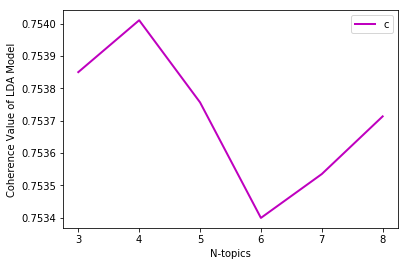

In [71]:
fig = plt.figure()
y = list(optimal_ntopics.mean())
x = [3,4,5,6,7,8]
plt.plot(x,y, 'm', linewidth=2)
plt.xlabel("N-topics")
plt.ylabel('Coherence Value of LDA Model')
plt.legend(("coherence_values"), loc='best')

In [72]:
## Model
tweet_lda_topic1 = {}
tweet_lda_score1 = {}
for i in tweet_bow_noloc:
    if len(tweet_bow_noloc[i]) ==0:
        continue
    id2word = corpora.Dictionary([tweet_bow_noloc[i]])
    corpus = [id2word.doc2bow(w) for w in [tweet_bow_noloc[i]]]
    ldamodel4 = gensim.models.ldamodel.LdaModel(corpus, num_topics = 4, id2word=id2word,update_every=1, alpha='auto',passes=20)
    topics = ldamodel4.print_topics(num_words=3)
    
    cm4 = CoherenceModel(model=ldamodel4, texts=[tweet_bow_noloc[i]], dictionary=id2word, coherence='c_v')
    coherence_lda4 = cm4.get_coherence()
    
    tweet_lda_topic1[i] = topics
    tweet_lda_score1[i] = [ldamodel4.log_perplexity(corpus),coherence_lda4]

In [73]:
tweet_topic_dic = {}    
for i in tweet_lda_topic1:
    topic = []
    for t in tweet_lda_topic1[i]:
        formula = t[1].split()
        for w in formula:
            if w == '+':
                continue
            topic.append(re.sub(r'[^\w]','',w)[4:])
    tweet_topic_dic[i] = topic

In [74]:
## choose the top 5 frequency as final topics for each area
sort_topic = {}
for i in tweet_topic_dic:
    topic_fre = {}
    for w in tweet_topic_dic[i]:
        if nltk.tag.pos_tag([w])[0][1] == 'NN' or  nltk.tag.pos_tag([w])[0][1] == 'JJ' or nltk.tag.pos_tag([w])[0][1] == 'NNS':
            topic_fre[w] = bow_by_loc[i][w]
    sorted_topic_fre = sorted(topic_fre.items(), key = lambda item:item[1], reverse=True)
    sort_topic[i] = sorted_topic_fre[:5]

In [75]:
final_lda_topics = {}
for i in sort_topic:
    topic = []
    for t in sort_topic[i]:
        topic.append(t[0])
    final_lda_topics[i] = topic

In [76]:
with open('LDA_tweet_4topics.json', 'w') as f:
    data = json.dump(final_lda_topics, f)

In [77]:
lda_tweet_coherence = []
lda_tweet_perplexity = []
for i in tweet_lda_score1:
    lda_tweet_coherence.append(tweet_lda_score1[i][1])
    lda_tweet_perplexity.append(tweet_lda_score1[i][0])

Text(0, 0.5, 'Count of Areas')

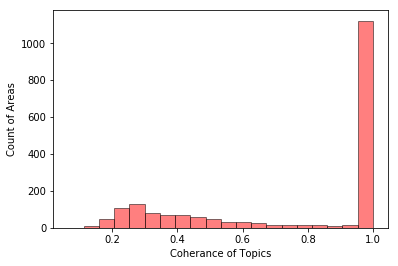

In [78]:
plt.hist(lda_tweet_coherence, bins = 20,facecolor="red", edgecolor="black", alpha=0.5)
plt.xlabel('Coherance of Topics')
plt.ylabel('Count of Areas')

Text(0, 0.5, 'Count of Areas')

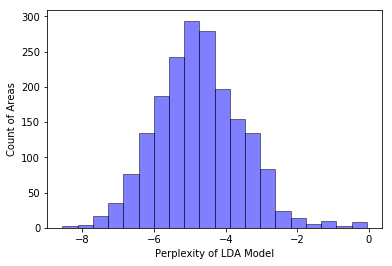

In [79]:
plt.hist(lda_tweet_perplexity, bins = 20,facecolor="blue", edgecolor="black", alpha=0.5)
plt.xlabel('Perplexity of LDA Model')
plt.ylabel('Count of Areas')
## Perplexity is not a good evaluation standard to measure the model. 
##使用gensim包的童鞋注意了，千万不要用log_perplexity()计算的perplexity指标来比较topic数量的好坏！因为这个函数没有对主题数目做归一化，因此不同的topic数目不能直接比较！

In [378]:
lda_score_table = pd.DataFrame()
lda_score_table['sa2_code'] = tweet_lda_score1.keys()
lda_score_table['lda_tweet_coherence'] = lda_tweet_coherence
lda_score_table['lda_tweet_perplexity'] = lda_tweet_perplexity
lda_score_table['topic'] = final_lda_topics.values()

In [81]:
lda_score_table.to_csv('tweet_4topics_lda_table.csv', index = False)

### pDMM

In [574]:
## 构建corpus
for i in range(0,1929):
    f = open('./corpus/test_tweet'+str(i), 'w')
    for j in clean_join_tweet[sa2_id[i]]:
            f.write(j+'\n')
    f.close()

In [247]:
## 读取output
import os
path = "pDMM-master/output_4topics/" #文件夹目录
files= os.listdir(path)

In [249]:
pDMM_topics = {}
pDMM_filter_topics={}
sa2 = list(tweet_bow_noloc.keys())
for i in range(0,1929):
    f = open(path+"/"+'dmmModel'+str(i)+'.topWords', 'r')
    lines = f.readlines()
    dic = {}
    t = []
    for line in lines:
        line = line.strip('\n')
        dic[line[:7]] = line[9:].split()
    pDMM_topics[sa2[i]] = dic
    if len(dic.keys()) == 0:
            continue
    else:
        for j in range(0,4):
            t.append([w for w in dic['Topic '+str(j)]])
    pDMM_filter_topics[sa2[i]] = t

In [257]:
tweet_pdmm = {}
for i in tweet_bow_noloc:
    if len(tweet_bow_noloc[i]) ==0:
        continue
    id2word = corpora.Dictionary([tweet_bow_noloc[i]])
    corpus = [id2word.doc2bow(w) for w in [tweet_bow_noloc[i]]]
    if len(pDMM_topics[i]) <4:
        continue
    pdmm_cm = CoherenceModel(topics=list(pDMM_topics[i].values()),texts=[tweet_bow_noloc[i]],corpus=corpus, dictionary = id2word,coherence='c_v')
    coherence_pdmm = pdmm_cm.get_coherence()
    
    tweet_pdmm[i] = [coherence_pdmm]

In [258]:
n = 0
for i in pDMM_topics:
    if len(pDMM_topics[i])<5:
        n+=1
n

1929

In [259]:
## choose the top 5 frequency as final topics for each area
pdmm_sort_topic = {}
for i in pDMM_filter_topics:
    topic_fre = {}
    whole_t = []
    for j in pDMM_filter_topics[i]:
        for w in j:
            whole_t.append(w)
    for w in whole_t:
        if nltk.tag.pos_tag([w])[0][1] == 'NN' or  nltk.tag.pos_tag([w])[0][1] == 'JJ' or nltk.tag.pos_tag([w])[0][1] == 'NNS':
            topic_fre[w] = bow_by_loc[i][w]
    sorted_topic_fre = sorted(topic_fre.items(), key = lambda item:item[1], reverse=True)
    pdmm_sort_topic[i] = sorted_topic_fre[:5]

In [260]:
final_pdmm_topics = {}
for i in pdmm_sort_topic:
    topic = []
    for t in pdmm_sort_topic[i]:
        topic.append(t[0])
    final_pdmm_topics[i] = topic

In [261]:
pdmm_sa2 = list(final_pdmm_topics.keys())
pdmm_top5 = list(final_pdmm_topics.values())
pdmm_coherence = [i[0] for i in list(tweet_pdmm.values())]

In [377]:
pdmm_df = pd.DataFrame()
pdmm_df['sa2_code'] = pdmm_sa2
pdmm_df['top5_topics'] = pdmm_top5
pdmm_df['pdmm_coherence'] = pdmm_coherence

In [265]:
pdmm_df.to_csv('pdmm_4topics_table.csv')

### Mallet LDA

In [269]:
gensim_ldamallet_topic = {}
ldamallet_score = {}
mallet_path = 'mallet-2.0.8/bin/mallet'
now = 0
for i in tweet_bow_noloc:
    print(now)
    if len(tweet_bow_noloc[i]) ==0:
        continue
    id2word = corpora.Dictionary([tweet_bow_noloc[i]])
    corpus = [id2word.doc2bow(w) for w in [tweet_bow_noloc[i]]]
    
    ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=4, id2word=id2word)
    topics = ldamallet.print_topics(num_words=3)
    
    coherence_mallet_lda = CoherenceModel(model=ldamallet, texts=[tweet_bow_noloc[i]], dictionary=id2word, coherence='c_v')
    coherence_mallet = coherence_mallet_lda.get_coherence()
    
    gensim_ldamallet_topic[i] = topics
    ldamallet_score[i] = [coherence_mallet]
    now += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/anaconda3/lib/python3.7/site-packages/gensim/models/wrappers/ldamallet.py:448: RuntimeWarning: invalid value encountered in true_divide
  topic = topic / topic.sum()  # normalize to probability dist
/anaconda3/lib/python3.7/site-packages/gensim/models/wrappers/ldamallet.py:379: RuntimeWarning: invalid value encountered in true_divide
  return topics / topics.sum(axis=1)[:, None]


503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606
607
608
609
610
611
612
613
614
615
616
617
618
619
620
621
622
623
624
625
626
627
628
629
630
631
632
633
634
635
636
637
638
639
640
641
642
643
644
645
646
647
648
649
650
651
652
653
654
655
656
657
658
658
659
659
660
661
662
663
664
665
666
667
668
669
670
671
672
673
674
675
676
677
678
679
680
681
682
683
684
685
686
687
688
689
690
691
692
693
694
695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750


In [313]:
## 提取并整合所有的topics
mallet_topic_dic = {}    
for i in gensim_ldamallet_topic:
    topic = []
    for t in gensim_ldamallet_topic[i]:
        formula = t[1].split()
        for w in formula:
            if w == '+':
                continue
            elif w.startswith('nan'):
                topic.append(re.sub(r'[^\w]','',w)[3:])
            else:
                topic.append(re.sub(r'[^\w]','',w)[4:])
    mallet_topic_dic[i] = topic

In [314]:
mallet_sort_topic = {}
for i in mallet_topic_dic:
    topic_fre = {}
    for w in mallet_topic_dic[i]:
        if nltk.tag.pos_tag([w])[0][1] == 'NN' or  nltk.tag.pos_tag([w])[0][1] == 'JJ' or nltk.tag.pos_tag([w])[0][1] == 'NNS':
            topic_fre[w] = bow_by_loc[i][w]
    sorted_topic_fre = sorted(topic_fre.items(), key = lambda item:item[1], reverse=True)
    mallet_sort_topic[i] = sorted_topic_fre[:5]

In [316]:
final_mallet_topics = {}
for i in mallet_sort_topic:
    topic = []
    for t in mallet_sort_topic[i]:
        topic.append(t[0])
    final_mallet_topics[i] = topic

In [375]:
mallet_sa2 = list(final_mallet_topics.keys())
mallet_top5 = list(final_mallet_topics.values())
mallet_coherence = [i[0] for i in list(ldamallet_score.values())]

In [376]:
mallet_df = pd.DataFrame()
mallet_df['mallet_sa2_code'] = mallet_sa2
mallet_df['mallet_top5_topics'] = mallet_top5
mallet_df['mallet_coherence'] = mallet_coherence

In [326]:
mallet_df.to_csv('mallet_table.csv')

In [327]:
with open('Mallet_tweet_all_topics.json', 'w') as f:
    data = json.dump(gensim_ldamallet_topic, f)

### LDA vs. Mallet vs. PDMM

In [379]:
## Combine tables to draw box plot
lda_score_table.set_index(["sa2_code"], inplace=True)
mallet_df.set_index(['mallet_sa2_code'], inplace = True)
pdmm_df.set_index(['sa2_code'], inplace = True)

lda_name = ['LDA_coherence', 'LDA_perplexity', 'LDA_topic']
ma_name = ['MALLET_topic', 'MALLET_coherence']
pdmm_name = ['PDMM_topic', 'PDMM_coherence']
lda_score_table.columns = lda_name
mallet_df.columns = ma_name
pdmm_df.columns = pdmm_name


In [380]:
comb_df = pd.concat([lda_score_table,mallet_df,pdmm_df], axis = 1, join='outer', sort = False)

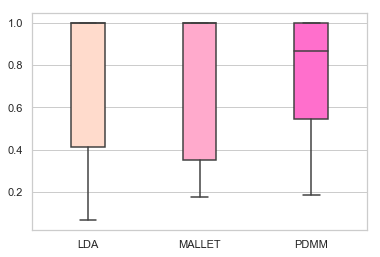

In [479]:
data = pd.DataFrame()
data['LDA'] = list(comb_df['LDA_coherence'])
data['MALLET'] = list(comb_df['MALLET_coherence'])
data['PDMM'] = list(comb_df['PDMM_coherence'])

import seaborn as sns
sns.set(style="whitegrid")
ax = sns.boxplot(data=data,palette="Blues",width=0.3, dodge = False)
for patch in ax.artists:
    r, g,b,a = patch.get_facecolor()
    patch.set_facecolor((a, g, .8))

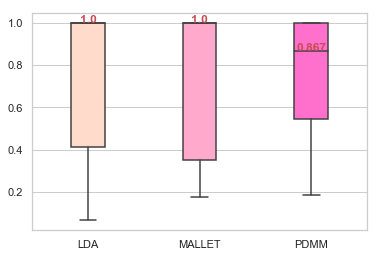

In [480]:
medians = [round(data['LDA'].median(), 3), round(data['MALLET'].median(), 3),round(data['PDMM'].median(), 3)]
median_labels = [str(s) for s in medians]

pos = range(len(medians))
for tick,label in zip(pos,ax.get_xticklabels()):
    ax.text(pos[tick], medians[tick], median_labels[tick], horizontalalignment='center', size='medium', color='r', weight='semibold')

ax.get_figure()

In [483]:
## mean
means = [round(data['LDA'].mean(), 3), round(data['MALLET'].mean(), 3),round(data['PDMM'].mean(), 3)]

In [484]:
means

[0.754, 0.746, 0.77]

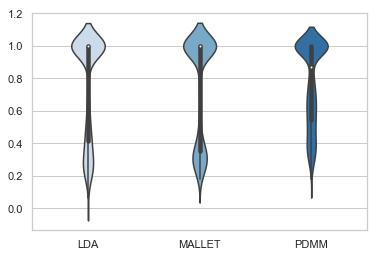

In [436]:
vx = sns.violinplot(data = data,palette="Blues",width=0.3, dodge = False)
for patch in vx.artists:
    r, g,b,a = patch.get_facecolor()
    patch.set_facecolor((a, g,r, .8))

In [481]:
comb_df.to_csv('3ModelsTable.csv')